In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader

from torch.optim import SGD, Adam

from tqdm import tqdm

The model is a standard multi-layer perceptron. Classification only requires a change to the output activation from None to sigmoid.

In [2]:
class nnet(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes):
        super(nnet, self).__init__()
        
        self.input_dim = input_dim
        self.layer_sizes = hidden_layer_sizes
        self.iter = 0
        
        hidden_layer_sizes = hidden_layer_sizes + [1] # Output layer
        first_layer = nn.Linear(input_dim, hidden_layer_sizes[0])
        self.layers = nn.ModuleList(
            [first_layer] +\
            [nn.Linear(input_, output_)
             for input_, output_ in 
             zip(hidden_layer_sizes, hidden_layer_sizes[1:])])

        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        
        return x
    
    def train(self, data_loader, epochs):
        for epoch in range(epochs):
            loss = self._train_iteration(data_loader)
            if epoch % 5 == 0:
                print(f"loss: {loss}")
                
    def _train_iteration(self,data_loader):
        for i, (X,y,g) in enumerate(data_loader):
            
            X = X.float()
            y = y.unsqueeze(1).float()
            
            X = Variable(X, requires_grad=True)
            y = Variable(y, requires_grad=True)
                      
            pred = self(X)
            loss = ((y - pred)**2).mean()
            
            optim.zero_grad()
            loss.backward()
            optim.step()
               
        return loss.detach().numpy()

# Data

The data generating process works as follows (story just for reference):
Revenue ($y_i$) depends on some characteristics $X_i$ of the customer i. Customers are given a coupon (treatment $g_i$) with 50% probability . Customer who receive a coupon will spend more or less money (treatment effect $\tau_i$) depending linearly on their characteristics.

$$y_i = X_i ^\top \beta_X + g_i \cdot (\tau_0 + X_i ^\top \beta_{\tau} + \epsilon^{\tau}_i) + \epsilon_i$$

with 

$$\epsilon_i \sim \text{Normal}(mean = 0, std = 0.1)$$

$$g_i \sim \text{Bernoulli}(p=0.5)$$
$$\epsilon^{\tau}_i \sim \text{Normal}(mean = 0, std = 0.001)$$

I think there is merit to the assumption that the true reponse model is often more complex than the model behind the heterogeneity of treatment effects. 


In [3]:
def generate_experiment(n_obs,n_var, tau=None):
    X = np.random.multivariate_normal(
             np.zeros(n_var),
             np.eye(n_var),
             n_obs
             )
    
    
    # Linear effects
    beta     = np.random.normal(scale=0.1, size=n_var)
    # Non-linear effects (optional)
    beta_X2  = np.random.normal(loc=0, scale=0.1, size=n_var)
    # Linear effects on treatment effect
    beta_tau = np.random.normal(loc=0,scale=0.01, size=n_var)
    # Baseline treatment effect
    tau_zero = np.random.normal(0.1,0.01)
    
    g = np.hstack([np.ones(n_obs//2), np.zeros(n_obs//2)])
        #np.random.binomial(1,0.5,size=n_obs)
        
    if tau is None:
        tau = tau_zero + np.dot(X,beta_tau) + np.random.normal(scale=0.001, size=n_obs)
        
    y = np.dot(X,beta) +\
        np.dot(np.power(X,2),beta_X2) +\
        g * tau + np.random.normal(scale=0.1, size=n_obs)
    
    return X, y, g, tau, beta, beta_X2, tau_zero, beta_tau
    
    

The Dataloader is currently a random sampler (see below) that returns $X_i$, $y_i$ and $g_i$ for a batch. 

TODO: I think a batch sampler stratified on $g$ makes more sense.

In [4]:
class ExperimentData(Dataset):
    def __init__(self, X, y, g):
        self.X = X
        self.y = y
        self.g = g
        
    def __len__(self):
        return X.shape[0]
    
    def __getitem__(self, idx):
        return X[idx,:], y[idx], g[idx]
                

In [5]:
X, y, g, tau, coef, coef_x2, tau_zero, coef_tau = generate_experiment(15000,10, tau=None)

For evaluation in the simulation context, I assume that the treatment effects are known and calculate the accuracy on the model in estimating the treatment effects on a holdout validation set. In practice, the true treatment effects are unknown, of course, so holdout evaluation is an open question.

In [6]:
np.mean(y), np.std(y)

(0.30378227001716507, 0.38715602598402266)

ATE summary statistics. These should be stable to confirm that the info-noise ratio in the data is not too high.

In [7]:
# True ATE and standard deviation of individual treatment effects
print(f"Baseline treatment effect (True ATE):{tau_zero}")
print(f"Sample treatment effect (ITE Mean, ITE Std.): {np.mean(tau), np.std(tau)}")
print(f"Empirical ATE: {np.mean(y[g==1]) - np.mean(y[g==0])}")

Baseline treatment effect (True ATE):0.09941928491355384
Sample treatment effect (ITE Mean, ITE Std.): (0.09968136775466813, 0.02549210466909146)
Empirical ATE: 0.09203177699345721


In [8]:
from sklearn.model_selection import train_test_split
X, X_val, y, y_val, g, g_val, tau, tau_val = train_test_split(X,y,g,tau, stratify=g)

In [ ]:
tau_

In [82]:
print(f"Baseline MSE for treatment effect prediction on validation data:\
      {np.mean((tau_val - np.mean(y[g==1]) - np.mean(y[g==0]))**2)}")

Baseline MSE for treatment effect prediction on validation data:      0.25560378150483054


In [9]:
data = ExperimentData(X,y,g)

## Mini-batch ATE causal net

### Model
The two-model approach estimates two distinct models on the response variable, one for each group. The difference between the two estimates for the same observations is the treatment effect for a single observation. Disjoint estimation may result in models that are not well calibrated.

Solution: Train a neural network to estimate the treatment effect directly. This is not possible for a single observation (-> fundamental problem of causal inference):

$$ r_i = \hat{\tau}_i - \tau_i, $$
where $\tau_i$ is of course unknown. 

We can however evaluate the total error for groups of observations $i \in 1,\ldots,N$:

$$ \sum^N r_i = \sum^N \hat{\tau}_i - \tau_i = \sum^N \hat{\tau}_i - \sum^N \tau_i$$


The sum treatment effect is only weakly informative for the treatment effect of a single observation and estimating the overall sum of treatment effects leaves too many degrees of freedom for the treatment effect of each observations. By using mini-batches instead, the summed individual treatment effects need to be correct not only for the population N, but also for each subset of the population $M \in N$.

The trick is in shuffling and reshuffling the observation between the batches. On the full sample, the model can get away with predicting the ATE for each observation. For the ATE *in each subset* to be correct, the model needs to predict the individual treatment effects correctly. 

TODO: Show this formally!

In [10]:
class causalnet1(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes):
        super().__init__()
        self.net = nnet(input_dim, hidden_layer_sizes)
        self.loss = []
        self.val_loss = []
        
    def forward(self, X):
        treatment_effect = self.net(X)
        return treatment_effect
    
    def train(self, data_loader, epochs, validation_data=None):
        for epoch in range(epochs):
            ATE, ATE_hat, loss, g_ratio = self._train_iteration(data_loader)
            self.loss.append(loss)
            if epoch % 5 == 0:
                if validation_data is not None:
                    tau_hat = self.net(validation_data['X'])
                    val_loss = (validation_data['tau'] - tau_hat).pow(2).mean().detach().numpy()
                    self.val_loss.append(val_loss)
                    print(f"val_loss: {val_loss}, ATE: {ATE}, ATE_hat: {ATE_hat}, loss: {loss}, balance: {g_ratio}")
                else:
                    print(f"ATE: {ATE}, ATE_hat: {ATE_hat}, loss: {loss}, balance: {g_ratio}")
            
    
    def _train_iteration(self,data_loader):
        for i, (X,y,g) in enumerate(data_loader):
            
            X = X.float()
            y = y.unsqueeze(1).float()
            
            X0 = Variable(X[g==0,:])
            y0 = Variable(y[g==0])
            
            X1 = Variable(X[g==1,:])
            y1 = Variable(y[g==1])
            
            g_ratio = g.float().mean()
            
#             response0 = self.net0(X0)
#             loss0 = ((y0 - response0)**2).mean()
            
#             response1 = self.net1(X1)
#             loss1 = ((y1 - response1)**2).mean()

            treatment_effect = self.net(X)
            
            ATE_hat = treatment_effect.mean()
            ATE     = y1.mean() - y0.mean()
            loss_treatment = (ATE - ATE_hat)**2            
            
            
#             if i % 2==0:
#                 self.net0.zero_grad()
#                 loss =  0*loss0 + loss_treatment
#                 loss.backward()
#                 optim0.step()
#             else:
            self.net.zero_grad()
            loss =  loss_treatment
            loss.backward()
            optim.step()
                
            
        return ATE.detach().numpy(), ATE_hat.detach().numpy(), loss.detach().numpy(), g_ratio
            

### Simulation

My intuition about the batch size is tradeoff: Too large and the signal from each observation becomes too small and predicting the ATE is the dominant strategy. Too small and the training becomes unstable.

TODO: A dynamic decrease in batch size could provide more and more information given that the model is stable enough to create decent estimates

TODO: Ideally, the data loader will pass bs/2 observations of each the treatment and the control group, but this will take some coding, so I ignore it for now. For small batch sizes, it's currently possible that not both groups are present in the batch so the loss will return NaN and training fails.

In [66]:
data_loader = DataLoader(data, batch_size=1024, shuffle=True)

We can train a FFNN without hidden layers as equivalent to the true linear regression model.

In [67]:
cnn1 = causalnet1(10, [])

A low learning rate is possibly necessary to stabilize training given the noise in the ATE within each batch.

In [68]:
optim = Adam(cnn1.net.parameters(), lr=0.001)

In [69]:
# optim0 = Adam(cnn.net0.parameters(), lr=0.001)
# optim1 = Adam(cnn.net1.parameters(), lr=0.001)

In [70]:
cnn1.train(data_loader, epochs=200, validation_data = {"X":torch.tensor(X_val).float(), 
                                              "tau":torch.Tensor(tau_val).float()})

val_loss: 0.3939637541770935, ATE: 0.10460539162158966, ATE_hat: -0.15642894804477692, loss: 0.06813892722129822, balance: 0.4663366377353668
val_loss: 0.3599683940410614, ATE: 0.09905397891998291, ATE_hat: -0.12370926141738892, loss: 0.049623459577560425, balance: 0.48712870478630066
val_loss: 0.33551907539367676, ATE: 0.12718407809734344, ATE_hat: -0.07809216529130936, loss: 0.04213833808898926, balance: 0.5178217887878418
val_loss: 0.32068872451782227, ATE: 0.09457835555076599, ATE_hat: -0.04236472770571709, loss: 0.018753409385681152, balance: 0.4821782112121582
val_loss: 0.3120989501476288, ATE: 0.11626145243644714, ATE_hat: 0.01940097101032734, loss: 0.009381953626871109, balance: 0.512871265411377
val_loss: 0.3062618672847748, ATE: 0.11410671472549438, ATE_hat: 0.02787178009748459, loss: 0.007436464074999094, balance: 0.4752475321292877
val_loss: 0.29948824644088745, ATE: 0.09965014457702637, ATE_hat: 0.06370097398757935, loss: 0.001292342902161181, balance: 0.49702969193458557


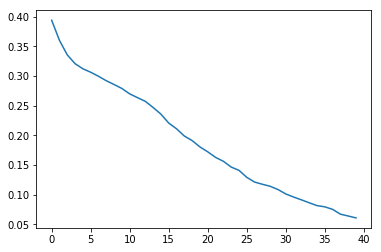

In [71]:
import matplotlib.pyplot as plt
plt.plot(cnn1.val_loss)
plt.show()

For neural networks without hidden layer, we can compare the coefficients to the known true coefficients.

The ATE is usually approximately correct.

In [72]:
tau_zero

0.09941928491355384

In [73]:
list(cnn1.net.parameters())[1].detach().numpy()

array([0.09392048], dtype=float32)

The estimated coefficients often don't capture the direction and even approximate size of the effect. 

In [74]:
coef_tau

array([-0.01181628, -0.00056324, -0.00038409, -0.0026142 ,  0.00355688,
       -0.01024895,  0.00623549,  0.00018308, -0.00534166, -0.01784753])

In [75]:
list(cnn1.net.parameters())[0].detach().numpy()

array([[ 0.02235821, -0.09537394,  0.03654303,  0.05068643,  0.12570445,
        -0.09733441,  0.04787605,  0.08505245, -0.03988213,  0.08098884]],
      dtype=float32)

The predicted treatment effects are usually not a accurate estimate of the true individual treatment effects, but correlation is at least positive.

In [76]:
pred = cnn1(torch.tensor(X).float()).detach().numpy()

In [77]:
print(tau.mean(), tau.std())
print(pred.mean(), pred.std())
print(np.corrcoef(tau,pred.flatten()))

0.09954795307329109 0.02537136176155067
0.09410434 0.23787782
[[1.         0.02499012]
 [0.02499012 1.        ]]


In [78]:
pred.flatten()[:10]

array([-0.10420389,  0.11199708, -0.20473675,  0.02476408, -0.19007854,
       -0.17463998,  0.21059147,  0.05530845,  0.02547589,  0.30920845],
      dtype=float32)

In [79]:
tau[:10]

array([0.12381572, 0.10763013, 0.04988213, 0.0977745 , 0.12228992,
       0.13137319, 0.1038555 , 0.10988424, 0.09399612, 0.09210034])

## Addditive two-model approach / residual network

### Model
Again estimate two networks jointly. Decompose the response estimate for treated observations into the response without treatment and the treatment effect. 

$$ \hat{y}_t = f_R(X_t) + f_T(X_t) \\
   \hat{y}_t = f_R(X_c)$$

One network $f_R$ predicts the response without treatment for each customer (treatment and control), the second network $f_T$ estimates the treatment effect. The loss for the first network is the response prediction MSE over all observations $$\frac{1}{N}\sum([\hat{y_t};\hat{y_c}] - [y_t;y_c])^2$$ the loss for the second network is the response prediction MSE for *only the treated group*, i.e. $$\frac{1}{N_T}\sum(\hat{y_t} - y_t)^2$$

TODO: This seems related to an approach called *covariate transformation* in the uplift literature. For covariate transformation, we estimate the outcome $y_i$ on a set of variables $[X_i, t_i \cdot X_i]$, where $t_i \cdot X_i$ is the interaction between the treatment indicator $t_i \in {0;1}$ and observed variables $X$. 

TODO: For the linear regression model, this is equivalent to including each variable-treatment interaction term (?)

In [25]:
class causalnet2(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes):
        super().__init__()
        self.net0 = nnet(input_dim, hidden_layer_sizes)
        self.net1 = nnet(input_dim, hidden_layer_sizes)
        self.loss = []
        self.val_loss = []
        
    def forward(self, X):
        return self.net1(X)
    
    def train(self, data_loader, epochs, validation_data=None):
        for epoch in range(epochs):
            ATE, ATE_hat, loss, g_ratio = self._train_iteration(data_loader)
            self.loss.append(loss)
            if epoch % 5 == 0:
                if validation_data is not None:
                    tau_hat = self.net1(validation_data['X'])
                    val_loss = (validation_data['tau'] - tau_hat).pow(2).mean().detach().numpy()
                    self.val_loss.append(val_loss)
                    print(f"val_loss: {val_loss}, ATE: {ATE}, ATE_hat: {ATE_hat}, loss: {loss}, balance: {g_ratio}")
                else:
                    print(f"ATE: {ATE}, ATE_hat: {ATE_hat}, loss: {loss}, balance: {g_ratio}")
            
    
    def _train_iteration(self,data_loader):
        for i, (X,y,g) in enumerate(data_loader):
            
            X = X.float()
            y = y.unsqueeze(1).float()
            
            X0 = Variable(X[g==0,:])
            y0 = Variable(y[g==0])
            
            X1 = Variable(X[g==1,:])
            y1 = Variable(y[g==1])
            
            g_ratio = g.float().mean()
            
            response0 = self.net0(X0)
            loss0 = ((y0 - response0).pow(2)).mean()
            
            response1 = self.net0(X1) + self.net1(X1)
            loss1 = ((y1 - response1).pow(2)).mean()
            
            loss = loss0 + loss1
            
            ATE_hat = response1.mean() - response0.mean()
            ATE     = y1.mean() - y0.mean()
            loss_treatment = (ATE - ATE_hat).pow(2)            
            
            self.net0.zero_grad()
            loss0.backward()
            optim0.step()

            self.net1.zero_grad()
            loss1.backward()
            optim1.step()
                
            
        return ATE.detach().numpy(), ATE_hat.detach().numpy(), loss.detach().numpy(), g_ratio
            

### Simulation

In [26]:
data_loader = DataLoader(data, batch_size=128, shuffle=True)

We can train a FFNN without hidden layers as equivalent to a linear regression model. Note that the true model for y is non-linear, while the true model for the treatment effect is linear.

In [27]:
cnn2 = causalnet2(10, [])

In [28]:
optim0 = Adam(cnn2.net0.parameters(), lr=0.001)
optim1 = Adam(cnn2.net1.parameters(), lr=0.001)

In [29]:
cnn2.train(data_loader, epochs=200, validation_data = {"X":torch.tensor(X_val).float(), 
                                              "tau":torch.Tensor(tau_val).float()})

val_loss: 0.31983739137649536, ATE: 0.039856791496276855, ATE_hat: 0.2881721258163452, loss: 0.7874999046325684, balance: 0.5087719559669495
val_loss: 0.05237380415201187, ATE: 0.03538721799850464, ATE_hat: 0.12635758519172668, loss: 0.1336619108915329, balance: 0.5087719559669495
val_loss: 0.0027038927655667067, ATE: 0.2698028087615967, ATE_hat: 0.2562141716480255, loss: 0.13276541233062744, balance: 0.4736842215061188
val_loss: 0.0014801514334976673, ATE: 0.14661186933517456, ATE_hat: 0.14969894289970398, loss: 0.14468304812908173, balance: 0.5263158082962036
val_loss: 0.001657499698922038, ATE: -0.004258185625076294, ATE_hat: 0.10067881643772125, loss: 0.13434848189353943, balance: 0.4649122953414917
val_loss: 0.0015906670596450567, ATE: 0.022585421800613403, ATE_hat: -0.040996626019477844, loss: 0.15352189540863037, balance: 0.45614033937454224
val_loss: 0.0016710431082174182, ATE: 0.1673550307750702, ATE_hat: 0.12963742017745972, loss: 0.1302785873413086, balance: 0.49122807383537

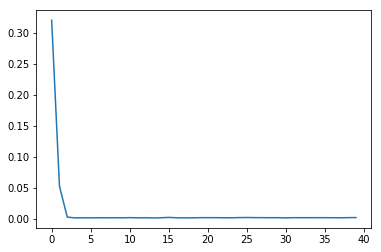

In [30]:
import matplotlib.pyplot as plt
plt.plot(cnn2.val_loss)
plt.show()

For neural networks without hidden layer, we can compare the coefficients to the known true coefficients.

In [31]:
tau_zero

0.09941928491355384

In [32]:
list(cnn2.net1.parameters())[1].detach().numpy()

array([0.09839207], dtype=float32)

The estimated coefficients usually capture the direction and even approximate size of the effect.

In [33]:
coef_tau

array([-0.01181628, -0.00056324, -0.00038409, -0.0026142 ,  0.00355688,
       -0.01024895,  0.00623549,  0.00018308, -0.00534166, -0.01784753])

In [34]:
list(cnn2.net1.parameters())[0].detach().numpy()

array([[-0.01961956,  0.00386629, -0.0082767 ,  0.00134611, -0.00027067,
        -0.01149784,  0.00668612, -0.00531666, -0.00999668, -0.01973524]],
      dtype=float32)

The predicted treatment effects are usually not a accurate estimate of the true individual treatment effects, but correlation is often high.

In [35]:
pred = cnn2.net1(torch.tensor(X).float()).detach().numpy()

In [36]:
print(tau.mean(), tau.std())
print(pred.mean(), pred.std())
print(np.corrcoef(tau,pred.flatten()))

0.09954795307329109 0.02537136176155067
0.09848804 0.033865847
[[1.         0.90684453]
 [0.90684453 1.        ]]


In [37]:
pred.flatten()[:10]

array([0.12902333, 0.11898324, 0.0572401 , 0.08173908, 0.14059615,
       0.13592334, 0.11062738, 0.13640127, 0.09566238, 0.08779384],
      dtype=float32)

In [38]:
tau[:10]

array([0.12381572, 0.10763013, 0.04988213, 0.0977745 , 0.12228992,
       0.13137319, 0.1038555 , 0.10988424, 0.09399612, 0.09210034])